# Imports and Functions

In [1]:
import math 
import matplotlib
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return dist*pen

def sim_anneal_iso():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


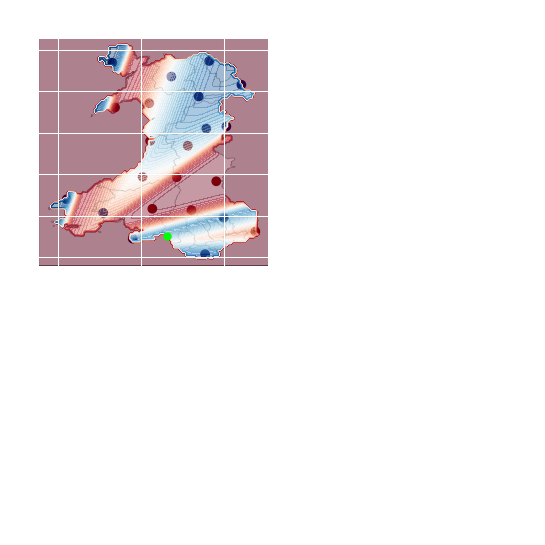

iteration  1
Accuracy is 0.5675831570851759
sim_anneal_isolated coord: (17.941705452307115, 4.525491810554759) distance: [[25.99918281]]
iteration  2
Accuracy is 0.5541242068832917
sim_anneal_isolated coord: (47.47096562027201, 6.219087101388844) distance: [[26.30435884]]
iteration  3
Accuracy is 0.560661411267064
sim_anneal_isolated coord: (2.0458500654106464, 13.99811809683304) distance: [[18.50429321]]
iteration  4
Accuracy is 0.5639300134589502
sim_anneal_isolated coord: (44.10239385624011, 41.58445750676783) distance: [[16.97479948]]
iteration  5
Accuracy is 0.5789271293981927
sim_anneal_isolated coord: (13.020509835176473, 46.89644637286813) distance: [[14.60905141]]
iteration  6
Accuracy is 0.6366083445491252
sim_anneal_isolated coord: (32.103433357881386, 11.37079379821067) distance: [[15.54425403]]
iteration  7
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (20.31070450344255, 19.372660392918775) distance: [[13.2330822]]
iteration  8
Accuracy is 0.756393001345895
sim

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.8177273601230532
sim_anneal_isolated coord: (36.36894455241338, 47.3150814289579) distance: [[8.92223175]]
iteration  20
Accuracy is 0.5608536819842338
sim_anneal_isolated coord: (39.83087808970575, 9.57510563899811) distance: [[7.93334091]]
iteration  21
Accuracy is 0.5510478754085752
sim_anneal_isolated coord: (26.27162848796602, 5.221442821221243) distance: [[7.42182769]]
experiment:  1


<IPython.core.display.Javascript object>


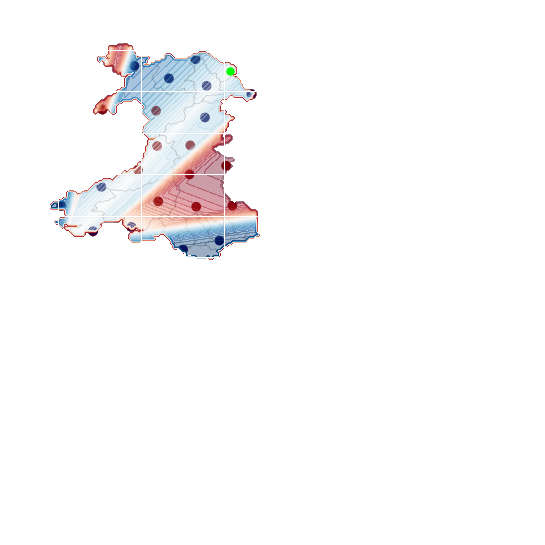

iteration  1
Accuracy is 0.4437608152278408
sim_anneal_isolated coord: (18.337666649996955, 46.12707632960229) distance: [[41.13438998]]
iteration  2
Accuracy is 0.7039030955585465
sim_anneal_isolated coord: (35.33310960274128, 33.70465227886238) distance: [[21.05140614]]
iteration  3
Accuracy is 0.6737165929628918
sim_anneal_isolated coord: (0.6992460211447522, 12.443165968862793) distance: [[31.21018271]]
iteration  4
Accuracy is 0.6671793885791194
sim_anneal_isolated coord: (19.263016128428955, 20.99419303421018) distance: [[20.43853284]]
iteration  5
Accuracy is 0.6887137089021342
sim_anneal_isolated coord: (33.073340536476564, 47.71294779052095) distance: [[14.1893939]]
iteration  6
Accuracy is 0.6767929244376082
sim_anneal_isolated coord: (10.60835872377235, 35.66905682082918) distance: [[13.00432132]]
iteration  7
Accuracy is 0.6721784272255336
sim_anneal_isolated coord: (17.631997912367282, 7.3796619342937575) distance: [[13.59669375]]
iteration  8
Accuracy is 0.545472024610651

<IPython.core.display.Javascript object>


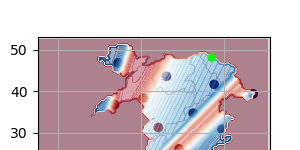

iteration  1
Accuracy is 0.4451067102480292
sim_anneal_isolated coord: (14.416699048604784, 46.84114806218021) distance: [[39.09251895]]
iteration  2
Accuracy is 0.6744856758315708
sim_anneal_isolated coord: (24.085801064078794, 31.280674961409712) distance: [[18.31993059]]
iteration  3
Accuracy is 0.5227840799846183
sim_anneal_isolated coord: (0.06280002438393684, 13.179700762999705) distance: [[29.54006359]]
iteration  4
Accuracy is 0.535858488752163
sim_anneal_isolated coord: (37.545057792384746, 41.66949228627927) distance: [[17.00232681]]
iteration  5
Accuracy is 0.67525475870025
sim_anneal_isolated coord: (14.273908835142976, 18.619689119861313) distance: [[15.21673707]]
iteration  6
Accuracy is 0.6975581618919439
sim_anneal_isolated coord: (36.6797225691015, 23.510090252239472) distance: [[14.61463994]]
iteration  7
Accuracy is 0.6362238031147857
sim_anneal_isolated coord: (18.85935504268949, 4.133771706247443) distance: [[12.54885056]]
iteration  8
Accuracy is 0.640453758892520

<IPython.core.display.Javascript object>


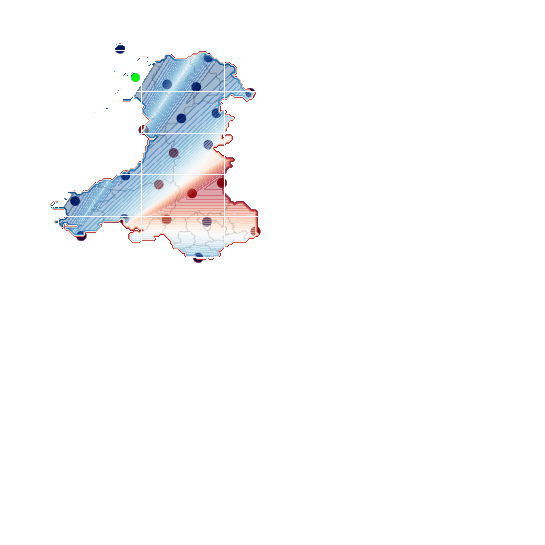

iteration  1
Accuracy is 0.5462411074793309
sim_anneal_isolated coord: (36.1750095148474, 48.14798966475023) distance: [[40.313273]]
iteration  2
Accuracy is 0.6383387810036532
sim_anneal_isolated coord: (14.945599961922047, 38.65202716501443) distance: [[23.25642134]]
iteration  3
Accuracy is 0.6379542395693136
sim_anneal_isolated coord: (27.79688223733542, 25.147632584375597) distance: [[16.12488326]]
iteration  4
Accuracy is 0.5756585272063065
sim_anneal_isolated coord: (38.122921269691766, 34.72448693497629) distance: [[13.56409915]]
iteration  5
Accuracy is 0.6062295712363007
sim_anneal_isolated coord: (16.16352375757797, 19.714319455565597) distance: [[12.83962309]]
iteration  6
Accuracy is 0.6029609690444145
sim_anneal_isolated coord: (47.45663624824853, 6.223171584173901) distance: [[21.54000125]]
iteration  7
Accuracy is 0.6031532397615843
sim_anneal_isolated coord: (39.38180466218299, 17.938707073610697) distance: [[13.64474385]]
iteration  8
Accuracy is 0.6052682176504518
si

<IPython.core.display.Javascript object>


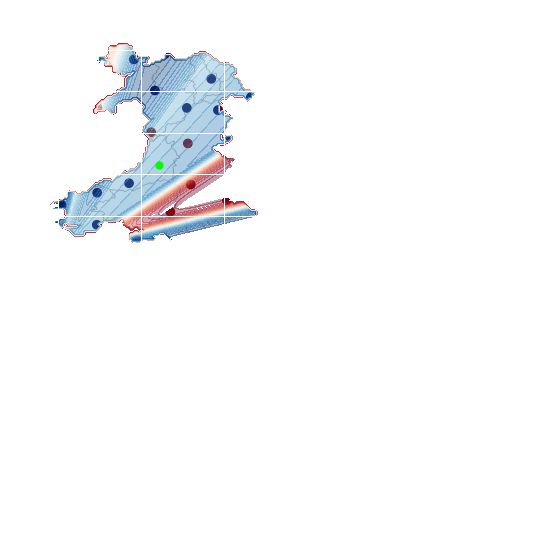

iteration  1
Accuracy is 0.6037300519130936
sim_anneal_isolated coord: (0.7894756482375325, 12.59267418845474) distance: [[33.84520615]]
iteration  2
Accuracy is 0.600845991155547
sim_anneal_isolated coord: (31.20270009560271, 2.086411882551271) distance: [[25.35803278]]
iteration  3
Accuracy is 0.6041145933474332
sim_anneal_isolated coord: (10.884620701709142, 47.44488932568322) distance: [[26.35154419]]
iteration  4
Accuracy is 0.6027686983272448
sim_anneal_isolated coord: (17.047817774495904, 17.856053642798884) distance: [[17.08908576]]
iteration  5
Accuracy is 0.6202653335896943
sim_anneal_isolated coord: (40.597506654145874, 13.763386438188814) distance: [[14.98713198]]
iteration  6
Accuracy is 0.6933282061142088
sim_anneal_isolated coord: (18.8493653078483, 4.218609464470969) distance: [[12.53599405]]
iteration  7
Accuracy is 0.694866371851567
sim_anneal_isolated coord: (9.427153504961655, 36.07813964687251) distance: [[11.45980841]]
iteration  8
Accuracy is 0.6694866371851567
s

<IPython.core.display.Javascript object>


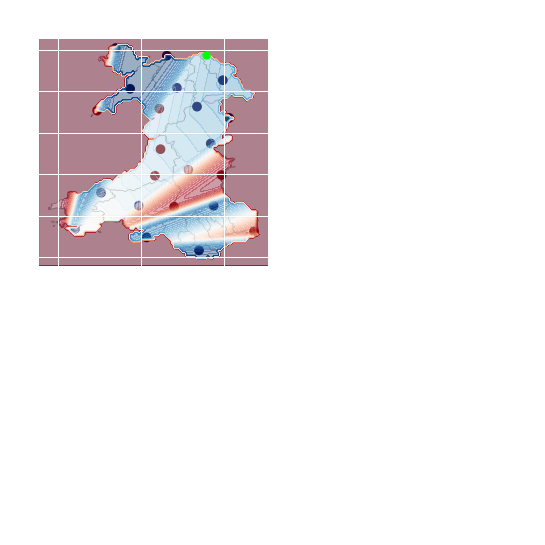

iteration  1
Accuracy is 0.3858873293597385
sim_anneal_isolated coord: (39.64875875735098, 42.67338729594276) distance: [[28.23389688]]
iteration  2
Accuracy is 0.5977696596808306
sim_anneal_isolated coord: (13.834090576724936, 50.41581042213042) distance: [[26.95073671]]
iteration  3
Accuracy is 0.6006537204383773
sim_anneal_isolated coord: (24.34126746215962, 35.82184159441156) distance: [[16.18981139]]
iteration  4
Accuracy is 0.5058642568736781
sim_anneal_isolated coord: (4.062049046735992, 6.900213679005497) distance: [[23.0742416]]
iteration  5
Accuracy is 0.5345125937319746
sim_anneal_isolated coord: (36.73196919183221, 27.425443187604525) distance: [[14.96759819]]
iteration  6
Accuracy is 0.5254758700249952
sim_anneal_isolated coord: (21.283766607961585, 4.812011640321071) distance: [[14.98856234]]
iteration  7
Accuracy is 0.5277831186310324
sim_anneal_isolated coord: (47.16142887483507, 6.2465053117229274) distance: [[11.54240975]]
iteration  8
Accuracy is 0.5037492789848106
s

<IPython.core.display.Javascript object>


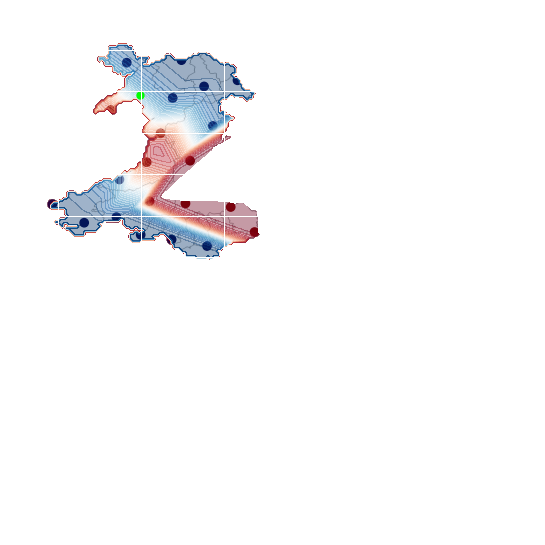

iteration  1
Accuracy is 0.5587387040953663
sim_anneal_isolated coord: (43.171771268975064, 42.65742943039781) distance: [[27.01033285]]
iteration  2
Accuracy is 0.6021918861757354
sim_anneal_isolated coord: (6.246209047680265, 8.343947505188092) distance: [[24.8305957]]
iteration  3
Accuracy is 0.6414151124783696
sim_anneal_isolated coord: (24.630061199237765, 29.87853111031412) distance: [[17.91537009]]
iteration  4
Accuracy is 0.5781580465295135
sim_anneal_isolated coord: (47.27833618664867, 6.097739722040856) distance: [[18.01656004]]
iteration  5
Accuracy is 0.5796962122668717
sim_anneal_isolated coord: (41.472234644014364, 23.177626953671012) distance: [[14.86607492]]
iteration  6
Accuracy is 0.6310324937512017
sim_anneal_isolated coord: (14.72504031516516, 18.763497793957114) distance: [[13.43345108]]
iteration  7
Accuracy is 0.6141126706402615
sim_anneal_isolated coord: (19.849824620078895, 5.437955377956042) distance: [[13.17322854]]
iteration  8
Accuracy is 0.5960392232263027

<IPython.core.display.Javascript object>


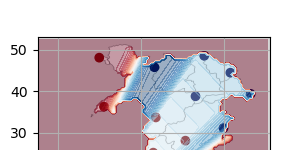

iteration  1
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (-0.022233368356749494, 8.4269674708653) distance: [[25.68359416]]
iteration  2
Accuracy is 0.6048836762161123
sim_anneal_isolated coord: (9.87393044796693, 48.10153473798369) distance: [[25.29176233]]
iteration  3
Accuracy is 0.5639300134589502
sim_anneal_isolated coord: (41.504387429545304, 10.388510049537487) distance: [[18.09468056]]
iteration  4
Accuracy is 0.562391847721592
sim_anneal_isolated coord: (39.80262171347759, 31.145559263275974) distance: [[18.01796193]]
iteration  5
Accuracy is 0.5939242453374352
sim_anneal_isolated coord: (23.489794622373505, 33.70439339985209) distance: [[16.51229723]]
iteration  6
Accuracy is 0.5381657373582004
sim_anneal_isolated coord: (32.25082290475282, 0.5637234568179352) distance: [[13.49647687]]
iteration  7
Accuracy is 0.5416266102672563
sim_anneal_isolated coord: (10.314159238347862, 18.339094803743954) distance: [[14.24192943]]
iteration  8
Accuracy is 0.629686598731013

<IPython.core.display.Javascript object>


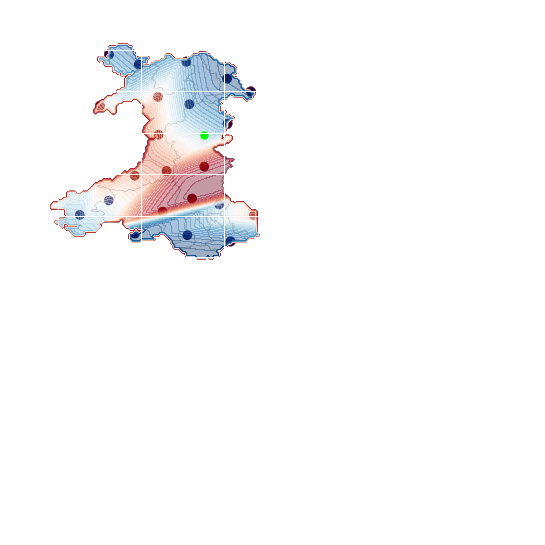

iteration  1
Accuracy is 0.551240146125745
sim_anneal_isolated coord: (19.37022402549914, 46.446158509696424) distance: [[29.1963623]]
iteration  2
Accuracy is 0.5629686598731013
sim_anneal_isolated coord: (40.66032273448493, 43.04334843716394) distance: [[21.56032049]]
iteration  3
Accuracy is 0.6410305710440299
sim_anneal_isolated coord: (31.087146904469854, 5.3364872840874975) distance: [[17.04650468]]
iteration  4
Accuracy is 0.6833301288213806
sim_anneal_isolated coord: (31.557589428281503, 36.87698981315974) distance: [[10.99471384]]
iteration  5
Accuracy is 0.6840992116900596
sim_anneal_isolated coord: (47.108199766228225, 10.099135334923558) distance: [[16.71397473]]
iteration  6
Accuracy is 0.7189002114977889
sim_anneal_isolated coord: (18.41781910006595, 19.66286409462432) distance: [[16.25784247]]
iteration  7
Accuracy is 0.6589117477408191
sim_anneal_isolated coord: (18.464117730223425, 5.717832036297776) distance: [[12.62878812]]
iteration  8
Accuracy is 0.7048644491443953

<IPython.core.display.Javascript object>


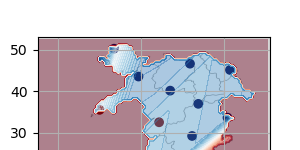

iteration  1
Accuracy is 0.5943087867717747
sim_anneal_isolated coord: (47.2241775379288, 10.372050784728511) distance: [[28.19445819]]
iteration  2
Accuracy is 0.5923860796000769
sim_anneal_isolated coord: (40.75365255849712, 33.65458282936769) distance: [[23.56313078]]
iteration  3
Accuracy is 0.5502787925398962
sim_anneal_isolated coord: (-1.6874174185715667, 12.64488273325146) distance: [[24.12011617]]
iteration  4
Accuracy is 0.5520092289944242
sim_anneal_isolated coord: (30.048935154795373, 3.617305391433365) distance: [[18.45577244]]
iteration  5
Accuracy is 0.6910209575081715
sim_anneal_isolated coord: (32.84368235234019, 21.833116760220395) distance: [[11.87048487]]
iteration  6
Accuracy is 0.6823687752355316
sim_anneal_isolated coord: (18.149196002018044, 8.515284467383076) distance: [[12.59410346]]
iteration  7
Accuracy is 0.6506441069025187
sim_anneal_isolated coord: (31.730113387017013, 46.65217027250824) distance: [[12.78748223]]
iteration  8
Accuracy is 0.686598731013266

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.8484906748702172
sim_anneal_isolated coord: (32.23252734375191, 29.241320842677702) distance: [[7.43337058]]
iteration  18
Accuracy is 0.6858296481445876
sim_anneal_isolated coord: (41.638711365859805, 23.428252516621544) distance: [[8.93851181]]
iteration  19


F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.8379157854258796
sim_anneal_isolated coord: (13.446619615856843, 50.25658073592366) distance: [[8.91281642]]
iteration  20
Accuracy is 0.7006344933666603
sim_anneal_isolated coord: (26.970956553595204, 40.16210089710639) distance: [[7.46432823]]
iteration  21
Accuracy is 0.705056719861565
sim_anneal_isolated coord: (4.602830198761383, 12.97612743194534) distance: [[6.29896326]]
experiment:  10


<IPython.core.display.Javascript object>


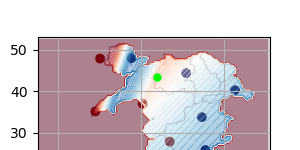

iteration  1
Accuracy is 0.5612382234185733
sim_anneal_isolated coord: (17.622676171161444, 47.99999796221866) distance: [[42.91903505]]
iteration  2
Accuracy is 0.5516246875600846
sim_anneal_isolated coord: (42.57028599781807, 40.27338530917046) distance: [[26.1167337]]
iteration  3
Accuracy is 0.6173812728321476
sim_anneal_isolated coord: (21.314384136875876, 20.493037787357544) distance: [[21.31735038]]
iteration  4
Accuracy is 0.6335320130744088
sim_anneal_isolated coord: (26.61632889516902, 5.869940406271768) distance: [[15.42466606]]
iteration  5
Accuracy is 0.6229571236300712
sim_anneal_isolated coord: (35.43549010947695, 25.851095256773476) distance: [[14.96384129]]
iteration  6
Accuracy is 0.6056527590847914
sim_anneal_isolated coord: (20.326214168527947, 36.996486981512916) distance: [[11.33077101]]
iteration  7
Accuracy is 0.6587194770236493
sim_anneal_isolated coord: (30.782666448342567, 44.39790281713198) distance: [[12.48837937]]
iteration  8
Accuracy is 0.596423764660642

<IPython.core.display.Javascript object>


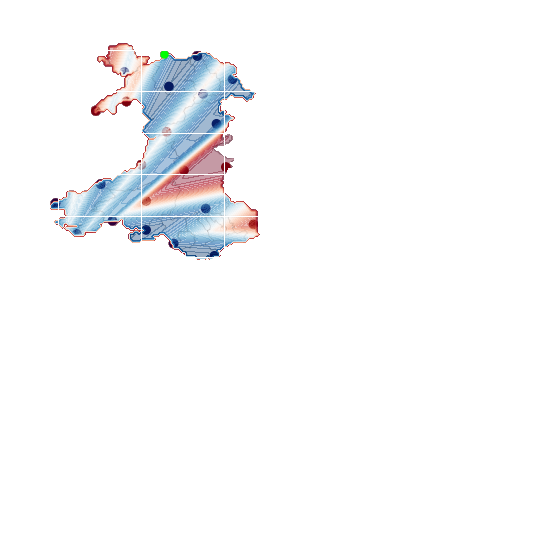

iteration  1
Accuracy is 0.485483560853682
sim_anneal_isolated coord: (37.60181733559498, 0.3639568083342102) distance: [[31.99300396]]
iteration  2
Accuracy is 0.48721399730820997
sim_anneal_isolated coord: (4.483934633357071, 5.649242377954648) distance: [[32.73478335]]
iteration  3
Accuracy is 0.5560469140549894
sim_anneal_isolated coord: (41.976158669674, 42.92750825345921) distance: [[20.32545355]]
iteration  4
Accuracy is 0.6075754662564892
sim_anneal_isolated coord: (21.176583294415636, 13.538559777899284) distance: [[17.39810693]]
iteration  5
Accuracy is 0.6683330128821381
sim_anneal_isolated coord: (40.36905284016621, 21.772611601764872) distance: [[16.57361819]]
iteration  6
Accuracy is 0.6844837531243991
sim_anneal_isolated coord: (26.66149074781523, 41.16103100080917) distance: [[10.95264691]]
iteration  7
Accuracy is 0.6817919630840223
sim_anneal_isolated coord: (47.013459714691585, 7.942351070961585) distance: [[12.08350412]]
iteration  8
Accuracy is 0.6425687367813882
s

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.6608344549125168
sim_anneal_isolated coord: (25.38959712731506, 48.94809005579884) distance: [[7.89024728]]
experiment:  12


<IPython.core.display.Javascript object>


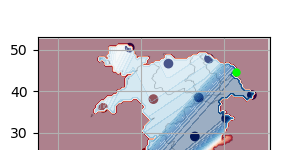

iteration  1
Accuracy is 0.3935781580465295
sim_anneal_isolated coord: (38.76847319222504, 1.7625391889675361) distance: [[27.97132797]]
iteration  2
Accuracy is 0.3943472409152086
sim_anneal_isolated coord: (17.209683302474772, 50.51102302214155) distance: [[25.57427509]]
iteration  3
Accuracy is 0.4906748702172659
sim_anneal_isolated coord: (0.28473951563294353, 12.535931024055364) distance: [[24.30846342]]
iteration  4
Accuracy is 0.5066333397423572
sim_anneal_isolated coord: (22.147962323872946, 4.729955048808353) distance: [[16.88333315]]
iteration  5
Accuracy is 0.505095174004999
sim_anneal_isolated coord: (36.315536547287735, 47.88694625323) distance: [[19.08415016]]
iteration  6
Accuracy is 0.5783503172466833
sim_anneal_isolated coord: (10.810308802917234, 36.02600839890277) distance: [[14.86484935]]
iteration  7
Accuracy is 0.6150740242261103
sim_anneal_isolated coord: (37.362669088070845, 16.146342775641436) distance: [[13.71166045]]
iteration  8
Accuracy is 0.650259565468179

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.7723514708709863
sim_anneal_isolated coord: (27.175004834020342, 16.504303935858207) distance: [[10.19395111]]
iteration  13
Accuracy is 0.5808498365698904
sim_anneal_isolated coord: (33.82959072452682, 38.49665838915566) distance: [[9.43157051]]
iteration  14
Accuracy is 0.6131513170544126
sim_anneal_isolated coord: (31.597417554968956, 7.163655278793683) distance: [[8.97753273]]
iteration  15
Accuracy is 0.6177658142664872
sim_anneal_isolated coord: (26.538372717231603, 46.67163408213293) distance: [[9.28452442]]
iteration  16
Accuracy is 0.6642953278215727
sim_anneal_isolated coord: (40.446956160476795, 33.488711225171706) distance: [[8.29873846]]
iteration  17
Accuracy is 0.6591040184579888
sim_anneal_isolated coord: (18.120868784541013, 16.91219804643099) distance: [[8.64759852]]
iteration  18
Accuracy is 0.6935204768313786
sim_anneal_isolated coord: (3.6934841776659493, 6.065023149183615) distance: [[7.31383544]]
iteration  19
Accuracy is 0.7189002114977889
sim_anne

<IPython.core.display.Javascript object>


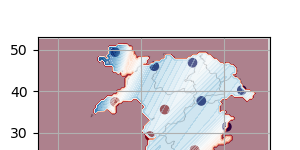

iteration  1
Accuracy is 0.5208613728129206
sim_anneal_isolated coord: (39.17928493401703, 5.602334479187075) distance: [[40.80212658]]
iteration  2
Accuracy is 0.5206691020957508
sim_anneal_isolated coord: (18.073063986932176, 7.822454113126149) distance: [[21.22266463]]
iteration  3
Accuracy is 0.5185541242068833
sim_anneal_isolated coord: (32.83546342533717, 25.82923730273627) distance: [[21.06563739]]
iteration  4
Accuracy is 0.47356277638915595
sim_anneal_isolated coord: (21.48831384855013, 20.182305100384863) distance: [[12.67460638]]
iteration  5
Accuracy is 0.41722745625841184
sim_anneal_isolated coord: (3.106586201769262, 12.863864915527788) distance: [[15.79276037]]
iteration  6
Accuracy is 0.5110555662372621
sim_anneal_isolated coord: (25.633678452719693, 35.60008314004132) distance: [[12.108304]]
iteration  7
Accuracy is 0.4353009036723707
sim_anneal_isolated coord: (44.21861215418255, 40.28993650036195) distance: [[13.5943393]]
iteration  8
Accuracy is 0.5433570467217843
s

<IPython.core.display.Javascript object>


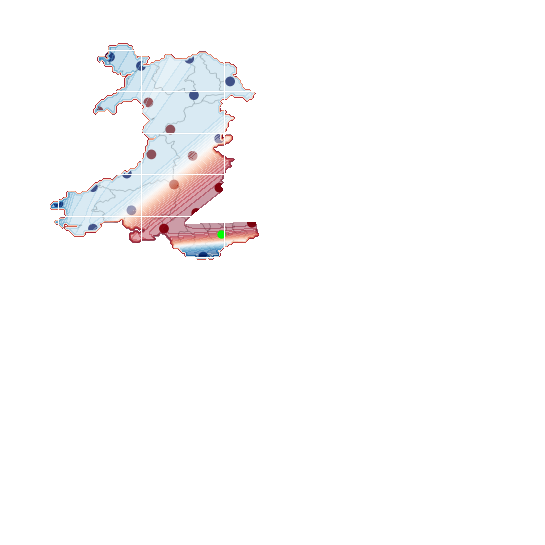

iteration  1
Accuracy is 0.4226110363391655
sim_anneal_isolated coord: (41.39369702569839, 42.3738753759005) distance: [[32.48366459]]
iteration  2
Accuracy is 0.5074024226110363
sim_anneal_isolated coord: (38.80237682519601, 16.787814875640393) distance: [[21.86730855]]
iteration  3
Accuracy is 0.5081715054797155
sim_anneal_isolated coord: (0.06900143786193352, 13.00429563141461) distance: [[17.63659655]]
iteration  4
Accuracy is 0.5200922899442415
sim_anneal_isolated coord: (27.005699942303874, 30.774870890924507) distance: [[17.86117331]]
iteration  5
Accuracy is 0.42491828494520284
sim_anneal_isolated coord: (19.924302664630314, 46.11168515293959) distance: [[14.93225561]]
iteration  6
Accuracy is 0.5372043837723515
sim_anneal_isolated coord: (38.75607457794324, 28.5785759669264) distance: [[11.79085201]]
iteration  7
Accuracy is 0.5208613728129206
sim_anneal_isolated coord: (34.93980124339227, 0.18920200585253077) distance: [[17.04210783]]
iteration  8
Accuracy is 0.57835031724668

<IPython.core.display.Javascript object>


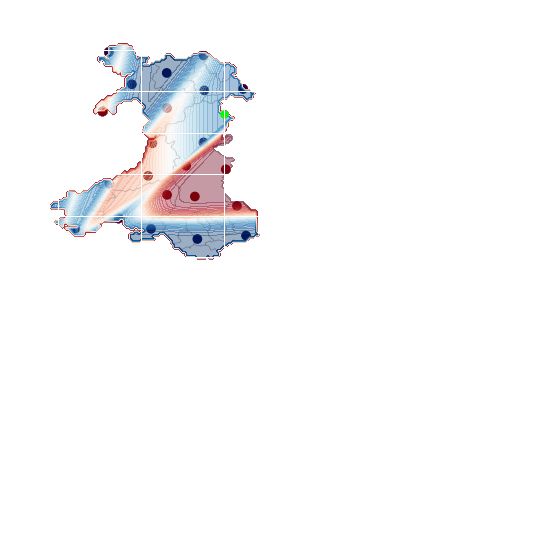

iteration  1
Accuracy is 0.6016150740242261
sim_anneal_isolated coord: (4.10900591869457, 6.9230792409075494) distance: [[29.81319122]]
iteration  2
Accuracy is 0.6366083445491252
sim_anneal_isolated coord: (12.22228609532463, 49.436640250657454) distance: [[24.72080966]]
iteration  3
Accuracy is 0.6362238031147857
sim_anneal_isolated coord: (22.691781102491685, 27.487912273971396) distance: [[16.3881499]]
iteration  4
Accuracy is 0.6048836762161123
sim_anneal_isolated coord: (12.32405210629195, 17.763115176393846) distance: [[13.60122652]]
iteration  5
Accuracy is 0.6064218419534705
sim_anneal_isolated coord: (26.123621499570007, 44.42447860608862) distance: [[9.96716276]]
iteration  6
Accuracy is 0.6012305325898866
sim_anneal_isolated coord: (45.22822934592243, 5.235677625593668) distance: [[15.522683]]
iteration  7
Accuracy is 0.6662180349932705
sim_anneal_isolated coord: (22.346369384498388, 6.887868838304302) distance: [[13.10982516]]
iteration  8
Accuracy is 0.6594885598923284
si

<IPython.core.display.Javascript object>


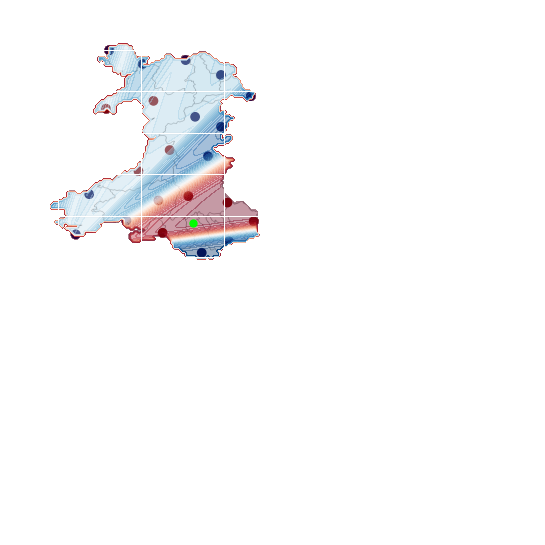

iteration  1
Accuracy is 0.5260526821765045
sim_anneal_isolated coord: (39.193361203607445, 43.94058509082353) distance: [[30.5178245]]
iteration  2
Accuracy is 0.571813112862911
sim_anneal_isolated coord: (41.14789205931036, 3.8987395477388938) distance: [[27.59017431]]
iteration  3
Accuracy is 0.5806575658527207
sim_anneal_isolated coord: (12.297052965762791, 49.87755421969946) distance: [[27.54376516]]
iteration  4
Accuracy is 0.5662372620649875
sim_anneal_isolated coord: (36.068196280140846, 24.36903486221692) distance: [[17.12573877]]
iteration  5
Accuracy is 0.5798884829840415
sim_anneal_isolated coord: (22.929010279625473, 37.692150201021576) distance: [[16.17166001]]
iteration  6
Accuracy is 0.5216304556815997
sim_anneal_isolated coord: (11.512187727754046, 35.83087921491901) distance: [[11.56754801]]
iteration  7
Accuracy is 0.45664295327821575
sim_anneal_isolated coord: (25.131567536423457, 5.926186232308199) distance: [[15.9469919]]
iteration  8
Accuracy is 0.574312632186118

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.8092674485675831
sim_anneal_isolated coord: (39.18822736192183, 31.460364735222726) distance: [[6.67336457]]
iteration  19
Accuracy is 0.6594885598923284
sim_anneal_isolated coord: (24.11816131757352, 13.706720351106641) distance: [[7.29273005]]
iteration  20
Accuracy is 0.6744856758315708
sim_anneal_isolated coord: (47.07053497240217, 8.682305379925811) distance: [[7.61315973]]
iteration  21
Accuracy is 0.6783310901749664
sim_anneal_isolated coord: (32.4329828793195, 8.20632303538468) distance: [[6.64695393]]
experiment:  17


<IPython.core.display.Javascript object>


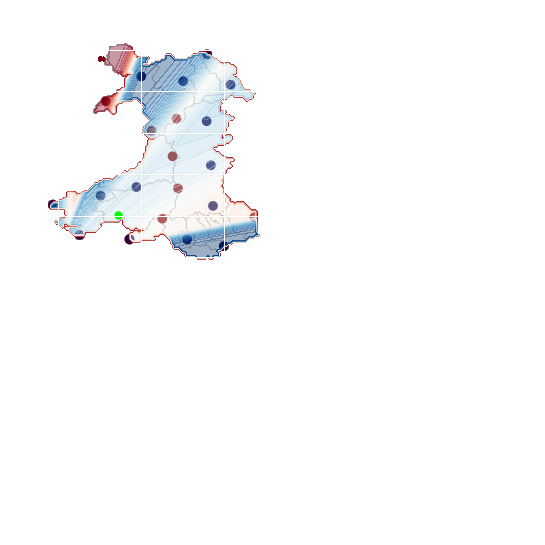

iteration  1
Accuracy is 0.5523937704287637
sim_anneal_isolated coord: (18.818733326524935, 16.93723642941985) distance: [[27.87874626]]
iteration  2
Accuracy is 0.5585464333781965
sim_anneal_isolated coord: (47.203990113223476, 9.656817517007951) distance: [[29.30404925]]
iteration  3
Accuracy is 0.5195154777927322
sim_anneal_isolated coord: (36.75866377407828, 22.187649496979837) distance: [[16.31338691]]
iteration  4
Accuracy is 0.5168236877523553
sim_anneal_isolated coord: (31.031895829741327, 4.351268802626821) distance: [[17.02014926]]
iteration  5
Accuracy is 0.5750817150547971
sim_anneal_isolated coord: (-1.29428499871246, 12.65860501961393) distance: [[20.56307839]]
iteration  6
Accuracy is 0.5881561238223418
sim_anneal_isolated coord: (41.50312031853733, 41.590406377010765) distance: [[11.46426819]]
iteration  7
Accuracy is 0.5885406652566814
sim_anneal_isolated coord: (22.439315684185623, 30.495197031534698) distance: [[14.03306496]]
iteration  8
Accuracy is 0.52143818496443

<IPython.core.display.Javascript object>


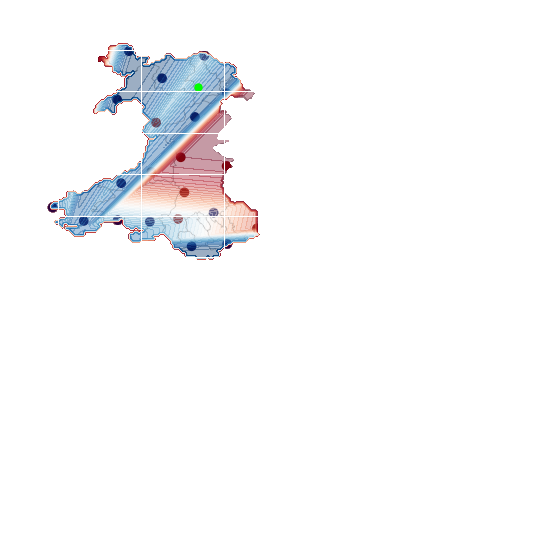

iteration  1
Accuracy is 0.3928090751778504
sim_anneal_isolated coord: (10.034113172980424, 48.11490077531075) distance: [[30.90791719]]
iteration  2
Accuracy is 0.3924245337435109
sim_anneal_isolated coord: (6.138999321152726, 8.782852481956418) distance: [[27.94508641]]
iteration  3
Accuracy is 0.49817342818688715
sim_anneal_isolated coord: (40.59280574195044, 39.52426089721759) distance: [[18.98693004]]
iteration  4
Accuracy is 0.58123437800423
sim_anneal_isolated coord: (25.005582852895994, 43.13617808716393) distance: [[15.77759754]]
iteration  5
Accuracy is 0.5835416266102672
sim_anneal_isolated coord: (22.05554639445357, 8.609985134206767) distance: [[15.52083079]]
iteration  6
Accuracy is 0.5787348586810229
sim_anneal_isolated coord: (14.170290885854186, 38.02503819872565) distance: [[10.90473718]]
iteration  7
Accuracy is 0.5881561238223418
sim_anneal_isolated coord: (15.150900607433588, 17.8765011691824) distance: [[11.55605698]]
iteration  8
Accuracy is 0.5973851182464911
si

<IPython.core.display.Javascript object>


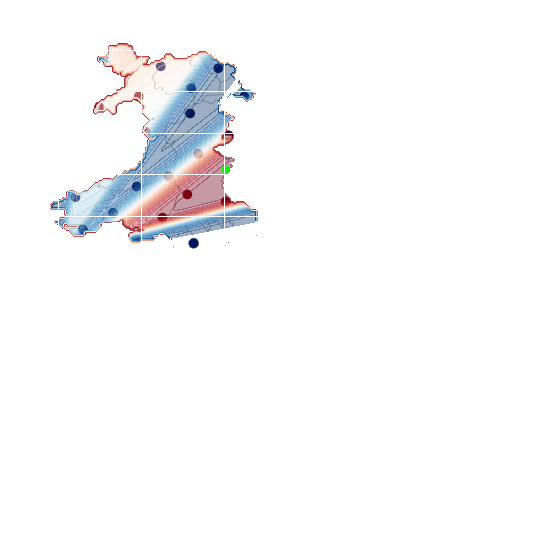

iteration  1
Accuracy is 0.4387617765814266
sim_anneal_isolated coord: (43.94941056758922, 5.578914071024231) distance: [[31.53556802]]
iteration  2
Accuracy is 0.44106902518746394
sim_anneal_isolated coord: (4.135031293354687, 14.505534364536109) distance: [[23.06779707]]
iteration  3
Accuracy is 0.5554701019034801
sim_anneal_isolated coord: (18.695486754850776, 4.612369667012794) distance: [[17.60345338]]
iteration  4
Accuracy is 0.5523937704287637
sim_anneal_isolated coord: (31.096732955964512, 15.16499893673766) distance: [[16.03384997]]
iteration  5
Accuracy is 0.6273793501249759
sim_anneal_isolated coord: (11.109547877840562, 48.00371030611153) distance: [[20.35687664]]
iteration  6
Accuracy is 0.6166121899634686
sim_anneal_isolated coord: (24.688351549051536, 46.02645356132838) distance: [[13.38512542]]
iteration  7
Accuracy is 0.6131513170544126
sim_anneal_isolated coord: (18.912085404270996, 17.057893724244266) distance: [[12.33080235]]
iteration  8
Accuracy is 0.6469909632762

<IPython.core.display.Javascript object>


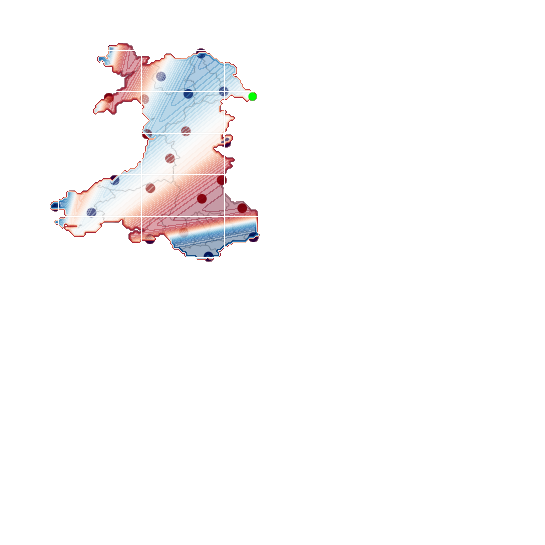

iteration  1
Accuracy is 0.5654681791963084
sim_anneal_isolated coord: (12.1340271866267, 50.32338456511362) distance: [[39.76005268]]
iteration  2
Accuracy is 0.5535473947317824
sim_anneal_isolated coord: (39.85505898909458, 39.96364076698619) distance: [[26.38202887]]
iteration  3
Accuracy is 0.6383387810036532
sim_anneal_isolated coord: (21.403074434800804, 29.733870035289772) distance: [[20.44805138]]
iteration  4
Accuracy is 0.5681599692366852
sim_anneal_isolated coord: (22.08078173542617, 4.41827521968014) distance: [[15.44109189]]
iteration  5
Accuracy is 0.6383387810036532
sim_anneal_isolated coord: (46.98909513492009, 4.872642639693941) distance: [[15.45765578]]
iteration  6
Accuracy is 0.6127667756200731
sim_anneal_isolated coord: (24.751431002440036, 43.55428682011926) distance: [[14.22024655]]
iteration  7
Accuracy is 0.6594885598923284
sim_anneal_isolated coord: (22.19749516646709, 16.64440163247155) distance: [[12.22668349]]
iteration  8
Accuracy is 0.6417996539127091
sim

F:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy is 0.7921553547394732
sim_anneal_isolated coord: (13.571222438726508, 18.570264703471814) distance: [[8.83863846]]
iteration  16
Accuracy is 0.6458373389732743
sim_anneal_isolated coord: (30.212638572790205, 5.924781011725008) distance: [[8.27022704]]
iteration  17
Accuracy is 0.6521822726398769
sim_anneal_isolated coord: (44.31718059103423, 11.839688097170152) distance: [[7.46182617]]
iteration  18
Accuracy is 0.635070178811767
sim_anneal_isolated coord: (20.70090874823776, 38.08197106245929) distance: [[6.80830157]]
iteration  19
Accuracy is 0.5912324552970583
sim_anneal_isolated coord: (30.737861110943268, 30.37294357858377) distance: [[7.58083127]]
iteration  20
Accuracy is 0.7719669294366468
sim_anneal_isolated coord: (39.34340546941779, 18.617541359849497) distance: [[6.54569845]]
iteration  21
Accuracy is 0.610267256296866
sim_anneal_isolated coord: (46.733286399702536, 38.8572798636987) distance: [[6.96663812]]


In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_iso()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 79.22 %
Improvement is = 22.67 %


In [11]:
np.savetxt('braninIsolatedSimAnnealnn', Results)